# Spot detection for RNA imaging, part II: quantifying gene expression

Neubias course. May 14 th and may 15 th 2025. Pasteur Institute. 

Teacher: Jacques Bourg    
Helper:  Gaëlle Letort

We are going in this part to cover the basic steps of quantifying gene expression using fluorescence in situ hybridisation (FISH imaging). 

Although this notebook is a follow up from the previous part, there is no need to have done it.

# Introduction 

Quantifying gene expression using FISH is vital as it provides spatial resolution, showing expression levels in individual cells and their location within tissue architecture. This reveals cell-to-cell heterogeneity and localization missed by bulk measurements.

Biological questions answered include: Which specific cell types express a gene? How does expression vary across different tissue regions? What is the extent of cell-to-cell variability in expression? How does spatial context influence gene activity?

In [53]:
import napari
import numpy as np
import pandas
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.segmentation import expand_labels

from bigfish.classification import prepare_extracted_data, features_dispersion, compute_features
from bigfish.multistack import detect_spots_colocalization

 
from detect_spots import DetectionPipeline
dt = DetectionPipeline()

from thresh_big_fish import SpotsThresholding
from cleaning import Cleaning
from quantify import Quantify

cl = Cleaning()
qf = Quantify()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
im = io.imread(Path('./data/D.tif'))

# split the channels in two : DAPI and FISH. Save as two separated files.
im_dapi  = im[...,0]
im_gene1 = im[...,1]
im_gene2 = im[...,2]

io.imsave( "dapi_image_2d.tif", im_dapi)
io.imsave( "fish_image_g1_2d.tif", im_gene1)
io.imsave( "fish_image_g2_2d.tif", im_gene2)

/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: dapi_image_2d.tif is a low contrast image
  return func(*args, **kwargs)
/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: fish_image_g1_2d.tif is a low contrast image
  return func(*args, **kwargs)
/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: fish_image_g2_2d.tif is a low contrast image
  return func(*args, **kwargs)


Load a Cellpose generated segmentation (unperfect but good enough for our purposes).

In [77]:
mask =  np.load('dapi_image_2d_seg.npy', allow_pickle=True)[()]
masks = mask['masks']

value_max_d  = np.percentile(im_dapi, 99.9)
value_max_g1 = np.percentile(im_gene1, 99.9)
value_max_g2 = np.percentile(im_gene2, 99.9)

viewer = napari.Viewer()
viewer.add_image(im_gene1, rgb=False, name=f" gene1 ", contrast_limits=(0, value_max_g1),  opacity=0.6,  colormap='green');
viewer.add_image(im_gene2, rgb=False, name=f" gene2 ", contrast_limits=(0, value_max_g2), opacity=0.6,  colormap='red');
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max_d), opacity=0.35);
viewer.add_labels(masks,   name=f" segmentation", opacity=0.2);

Determine the region in which we will acount for the rna expression:  To do so we use an algorithm called expand labels. 

This algorithm is designed to grow labeled regions (connected components) in a label image outwards by a specified distance. 

In [79]:
mask_bin = masks.copy()
mask_bin[mask_bin > 0] = 1

d = 40 # pixels
area_fish = expand_labels(mask_bin, distance=d)

viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max_d), opacity=0.5);
viewer.add_labels(mask_bin, name=f" binary mask of segmented cells", opacity=0.5);
viewer.add_labels(area_fish, name=f" fish expression area", opacity=0.5);


Cleaning the rois: retain only the nuclei with a big area. We do not want to keep nuclei that are too small since they can be parts of nuclei, or dying nuclei (become smaller).  

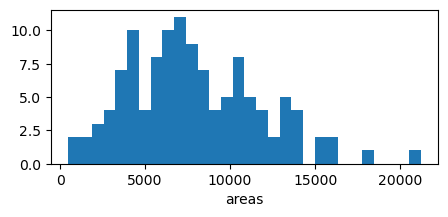

In [81]:
background_value = 0
labels, counts   = np.unique(masks, return_counts=True)

fig, ax = plt.subplots(figsize=(5,2))
ax.hist(counts[1:],bins= 30);
ax.set_xlabel('areas');

In [82]:
threshold = 5000 # try a threshold, observe the effect on the masks

labels_to_keep   = set(labels[counts >= threshold])   
if background_value in labels:
    labels_to_keep.add(background_value)

masks_nuclei = np.zeros(np.shape(masks), dtype=masks.dtype)
for label in labels_to_keep:
    masks_nuclei[masks == label] = label
        
value_max = np.percentile(im_dapi, 99.9)
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks,   name=f" segmentation");    
viewer.add_labels(masks_nuclei,   name=f" cleaned segmentation", blending='additive');    

spot detection: gene 1 and 2

As in the first notebook, we detect semi manually the spots. Just move the slider, observe the result, and close the window when you are satisfied with the threshold.

To get the Voxel size, I opened the D file in fiji and clicked on image/show Info.   

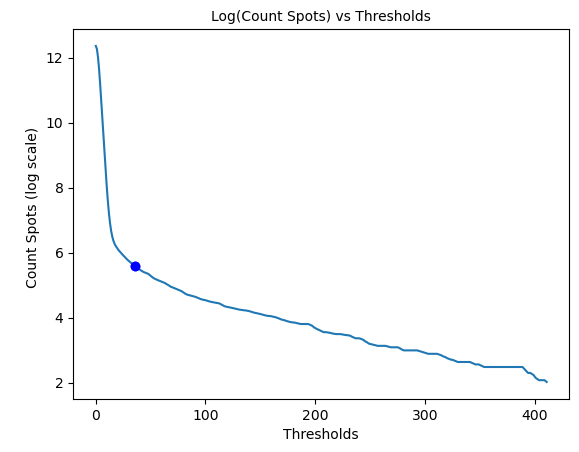

In [83]:
st_g1 = SpotsThresholding(BATCH=[Path('./fish_image_g1_2d.tif')], subtract_fish=False, voxel_size_nm=(112, 112), object_radius_nm=(150, 150)) 
st_g1.run();

In [84]:
spots_bf_g1 = st_g1.detected_spots['fish_image_g1_2d']

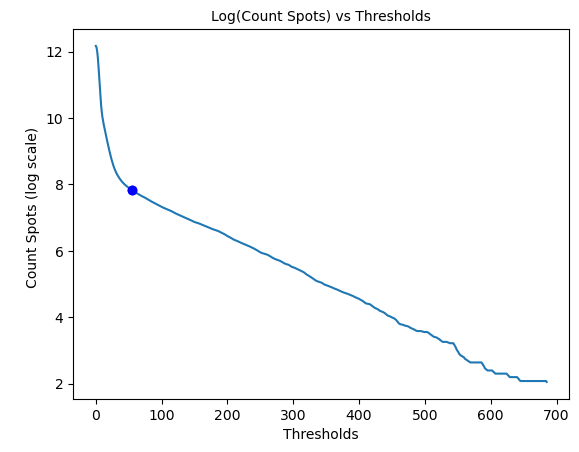

In [85]:
st_g2 = SpotsThresholding(BATCH=[Path('./fish_image_g2_2d.tif')], subtract_fish=False, voxel_size_nm=(112, 112), object_radius_nm=(150, 150)) # to get the Voxel size, I opened the "D.tif" file in fiji and clicked on image/show Info.   
st_g2.run();

In [86]:
spots_bf_g2 = st_g2.detected_spots['fish_image_g2_2d']

#### Clean the spots

a) Spots in the FISH expression area

In [88]:
spots_clean_g1, _ = cl.subsel_points_in_mask_fish(spots_bf_g1, area_fish)
spots_clean_g2, _ = cl.subsel_points_in_mask_fish(spots_bf_g2, area_fish)

Look at the next plot in detail and find spots which were excluded.

In [89]:
value_max = np.percentile(im_dapi, 99.9) 
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_nuclei,   name=f" nuclei cleaned segmentation"); 
viewer.add_labels(area_fish, name=f" fish expression area", opacity=0.5);
viewer.add_points(spots_bf_g1,   name=f" g1 raw spots",  size=2, face_color='green' ); 
viewer.add_points(spots_clean_g1,   name=f" g1 cleaned spots",  size=5, face_color=[0, 0, 0, 0], border_color= "#006400"); 
viewer.add_points(spots_bf_g2,   name=f" g2 raw spots",  size=2, face_color='red' ); 
viewer.add_points(spots_clean_g2,   name=f" g2 cleaned spots",  size=5, face_color=[0, 0, 0, 0], border_color= "#8B0000"); 

# Quantification

a) Spot intensity. Why does it makes sense to quantify spot intensity ? Assuming the spatial expression is very sparse, what would it be the reason to get variability in the spot intensity ? 

In [90]:
g1_int, g2_int = [], []     # measure the intensity of the spots in the corresponding images:
 
for pos in spots_clean_g1:
    g1_int.append(im_gene1[pos[0], pos[1]])

for pos in spots_clean_g2:
    g2_int.append(im_gene2[pos[0], pos[1]])

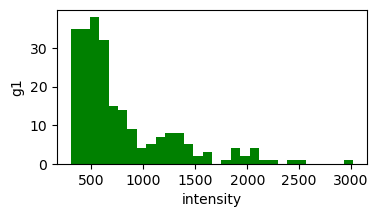

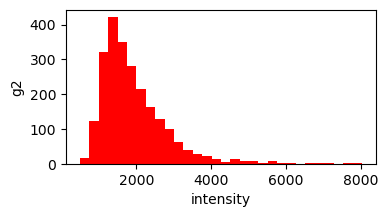

In [91]:
fig, ax = plt.subplots(figsize=(4,2))
ax.hist(g1_int, bins = 30, color='green');
ax.set_xlabel('intensity');
ax.set_ylabel('g1');

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(g2_int, bins = 30, color='red');
ax.set_xlabel('intensity');
ax.set_ylabel('g2');

Another way to measure gene expression is to quantify the spots width and sum the pixels in the estimated disk. 

1 - Biologically, why would one do this ? 

2- In the literature, people fit a gaussian to each spot and estimate the half-width of the gaussian.
What is the problem with taking the half-width ? Do you have a better idea to estimate the spots width ? 

b) Count matrix : count the spots/nuclei

In [92]:
area_bin_masks_clean = np.zeros_like(masks_nuclei)
area_bin_masks_clean[masks_nuclei >0] = 1

spots_clean_nuc_g1, _ = cl.subsel_points_in_mask_fish(spots_clean_g1, area_bin_masks_clean)
spots_clean_nuc_g2, _ = cl.subsel_points_in_mask_fish(spots_clean_g2, area_bin_masks_clean)

In [93]:
df_count_mat_g1  = qf.count_matrix(masks_nuclei, spots_clean_nuc_g1)
df_count_mat_g1

,cell_id,spot_count
0,1,1
1,3,1
2,4,0
3,5,0
4,6,4
...,...,...
85,115,0
86,116,3
87,117,3
88,118,4


In [94]:
df_count_mat_g2 = qf.count_matrix(masks_nuclei, spots_clean_nuc_g2)
df_count_mat_g2

,cell_id,spot_count
0,1,8
1,3,36
2,4,7
3,5,4
4,6,28
...,...,...
85,115,16
86,116,36
87,117,15
88,118,15


Check visually that we counted correctly the number of rna's by putting your mouse on the top nuclei.   
In napari the label L (in this case the nuclei id) can be seen at the bottom left of the window  [x,y]: L. 

In [97]:
value_max = np.percentile(im_dapi, 99.9)      # you can leave this napari window open
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_nuclei, name=f" nuclei cleaned segmentation", opacity=0.5);
viewer.add_points(spots_clean_nuc_g1,   name=f" g1 cleaned spots in nuclei",  size=5, face_color='green'); 
viewer.add_points(spots_clean_nuc_g2,   name=f" g2 cleaned spots in nuclei",  size=5, face_color='red'); 

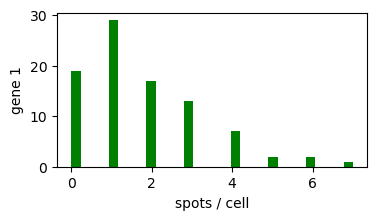

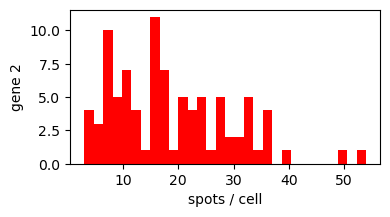

In [98]:
fig, ax = plt.subplots(figsize=(4,2))
ax.hist(df_count_mat_g1['spot_count'].values, bins =30, color = 'green');
ax.set_xlabel('spots / cell');
ax.set_ylabel('gene 1');

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(df_count_mat_g2['spot_count'].values, bins = 30, color = 'red');
ax.set_xlabel('spots / cell');
ax.set_ylabel('gene 2');

c) Subcellular/ subnuclear location

In Stueland et al.[2019], there are different indexes to characterize RNA distribution. 

Stueland, M., Wang, T., Park, H.Y. et al. RDI Calculator: An Analysis Tool to Assess RNA Distributions in Cells. Sci Rep 9, 8267 (2019). https://doi.org/10.1038/s41598-019-44783-2

Applying these indexes, the authors of the following paper revealed widespread co-translational RNA targeting to various cytoplasmic locations and identified specialized translation factories that compartmentalize translation and regulate nascent protein metabolism.

Chouaib, R., Safieddine, A., Pichon, X., Imbert, A., Kwon, O. S., Samacoits, A., Traboulsi, A. M., Robert, M. C., Tsanov, N., Coleno, E., et al. (2020). A dual protein–mRNA localization screen reveals compartmentalized translation and widespread co-translational RNA targeting. Developmental Cell, 54(6), 773–791.e5. https://doi.org/10.1016/j.devcel.2020.07.010


<div style="text-align: center;">
  <img src="misc/subcellular_location.png" alt="FISH imaging" width="706" height="439">
</div>

The polarization index (PI) and the dispersion index µ2 are computed as:

 
<div style="text-align: left;">
  <img src="misc/PI.png" alt=" " width="332" height="75" style="display: inline-block; margin-right: 5px; vertical-align: middle;">
  <img src="misc/DI.png" alt=" " width="176" height="75" style="display: inline-block; vertical-align: middle;">
</div>


Rg being the radius of gyration of the cell. 
r is the distance of the pixel (i,j) to the centroid of the RNA signal and I is the intensity value of pixel (i,j)
in the two dimensional image. 

The Peripheral Distribution Index (PDI) is calculated similar to the dispersion index, but in this case the second moment
 of RNA pixel intensity positions is calculated relative to the centroid of the nucleus


These indexes are implemented in bigfish.

In [99]:
# As we don't have the masks for the cells, and the nuclei are very packed 
# lets create artificially a mask for each cell making a dilation of the nuclei.

d = 2 # pixels
masks_cell = expand_labels(masks_nuclei, distance=d)

viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_cell, name=f" masks cells", opacity=0.5);
viewer.add_labels(masks_nuclei, name=f" masks nuclei", opacity=0.5, blending='additive');

Choose a nuclei in napari and note its label.
Verify that the number of points is the same as in napari.

We choose gene 2 as there are more spots on it.

In [100]:
lab_n  = 107                              
mask_c = np.zeros_like(masks_cell)
mask_c[masks_cell == lab_n] = 1

mask_n = np.zeros_like(masks_cell)
mask_n[masks_nuclei == lab_n] = 1
       
spot_nuclei_n, _ = cl.subsel_points_in_mask_fish(spots_clean_nuc_g2, mask_c)
print(len(spot_nuclei_n))         

32


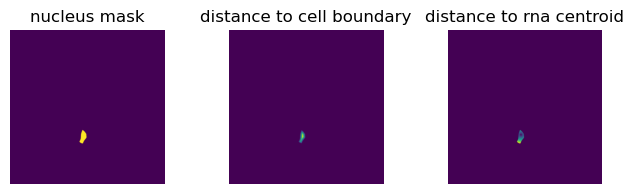

In [101]:
temp = prepare_extracted_data(mask_c, nuc_mask = mask_n,   rna_coord=spot_nuclei_n, ndim= 2)
(cell_mask, 
distance_cell,
distance_cell_normalized,
centroid_cell,
distance_centroid_cell,
nuc_mask,
cell_mask_out_nuc,
distance_nuc,
distance_nuc_normalized,
centroid_nuc,
distance_centroid_nuc,
rna_coord_out_nuc,
centroid_rna,
distance_centroid_rna,
centroid_rna_out_nuc,
distance_centroid_rna_out_nuc,
distance_centrosome) = temp


fig, ax = plt.subplots(1,3,figsize=(8,2))
ax[0].imshow(cell_mask); ax[0].set_axis_off(); ax[0].set_title('nucleus mask');
ax[1].imshow(distance_cell); ax[1].set_axis_off(); ax[1].set_title('distance to cell boundary');
ax[2].imshow(distance_centroid_rna); ax[2].set_axis_off(); ax[2].set_title('distance to rna centroid');

In [102]:
ndim = 2
index_polarization, index_dispersion, index_peripheral_distribution = features_dispersion(im_gene2, spot_nuclei_n, centroid_rna, cell_mask, centroid_cell, centroid_nuc, ndim, check_input=False)

print(f"Polarization index : {index_polarization}")
print(f"Dispersion index : {index_dispersion}")
print(f"Peripheral distribution index: {index_peripheral_distribution}")


Polarization index : 0.6124465317764333
Dispersion index : 0.541591513842054
Peripheral distribution index: 0.9774482015523206


Comment on the results of these indexes and on the spatial distributions we observe in our data.

#### d) Colocalization 

When we do the experiment with two or more genes, we can study their colocalization, which means to what extent two genes are expressed together in a given spatial scale. 

Studying the colocalization of two genes helps reveal their functional relationships, shared regulatory mechanisms, and potential combined effects on disease development

In [103]:
value_max = np.percentile(im_dapi, 99.9)      # you can leave this napari window open
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_nuclei, name=f" cleaned segmentation", opacity=0.5);
viewer.add_points(spots_clean_nuc_g1,   name=f" g1 cleaned spots in nuclei",  size=5, face_color='green'); 
viewer.add_points(spots_clean_nuc_g2,   name=f" g2 cleaned spots in nuclei",  size=5, face_color='red'); 

d.1 The first information we want to know is whether two genes are expressed in a same cell.

In [104]:
df_bin_coloc = qf.bin_colocalization(masks_nuclei, spots_clean_nuc_g1, spots_clean_nuc_g2)
df_bin_coloc

,cell_id,bin_coloc
0,1,True
1,3,True
2,4,False
3,5,False
4,6,True
...,...,...
85,115,False
86,116,True
87,117,True
88,118,True


Choose a cell and verify manually that the algorithm output coherent results

In [105]:
df_bin_coloc[df_bin_coloc['cell_id']==106]   

,cell_id,bin_coloc
78,106,False


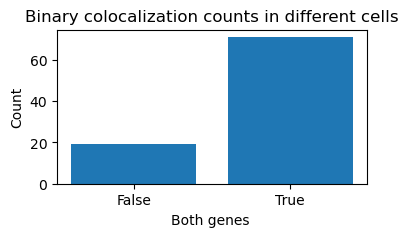

In [106]:
count_ones  = np.sum(df_bin_coloc['bin_coloc'].values*1 == 1)
count_zeros = np.sum(df_bin_coloc['bin_coloc'].values*1 == 0)

fig, ax = plt.subplots(figsize=(4, 2))
ax.bar([0, 1], [count_zeros, count_ones], tick_label=['False', 'True'])
ax.set_xlabel('Both genes ')
ax.set_ylabel('Count')
ax.set_title('Binary colocalization counts in different cells')
plt.show()

d.1 We also may ask if the proportion of genes that are expressed at the same spatial location.

In [107]:
pixel_size = 112
threshold  = pixel_size*2    # you can play with this variable, for instance threshold = pixel_size*5
spots_1_colocalized, spots_2_colocalized, distances, pixel_size, indices_2, threshold = detect_spots_colocalization(spots_clean_nuc_g1, spots_clean_nuc_g2, pixel_size, threshold=threshold, return_indices=True, return_threshold=True)

viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_nuclei, name=f" cleaned segmentation", opacity=0.5);
viewer.add_points(spots_1_colocalized,   name=f" g1 colocalization spots",  size=5, face_color='green'); 
viewer.add_points(spots_2_colocalized,   name=f" g2 colocalization spots",  size=5, face_color='red'); 

Lets define the proportion of colocalization at a given distance as the proportion of spots at a distance lower than a threshold over the minimum of spots of both genes.
What if there would be a gene with a lot of spots, and another with a small number of spots. What if the second has all its 
spots matched ? Could you propose another definition ? 

<div style="text-align: center;">
  <img src="misc/colocalization.png" alt="FISH imaging" width="410" height="75">
</div>

In [108]:
n1 = len(spots_clean_nuc_g1)
n2 = len(spots_clean_nuc_g2)
pix_siz = 112
dist_pix = np.arange(1,40)
thresh_arr = (dist_pix*pix_siz).astype(float)

prop_coloc = []
for thresh in thresh_arr:
    spots_1_colocalized, spots_2_colocalized, distances, pixel_size, indices_2, threshold = \
                detect_spots_colocalization(spots_clean_nuc_g1, spots_clean_nuc_g2, pix_siz, threshold=thresh, return_indices=True, return_threshold=True)
    prop = 100*len(spots_1_colocalized)/np.min([n1,n2])
    
    prop_coloc.append(prop)

Text(0, 0.5, '% colocalization')

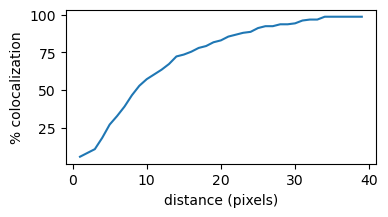

In [109]:
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(dist_pix, prop_coloc)
ax.set_xlabel('distance (pixels)')
ax.set_ylabel("% colocalization")